In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams.update({
    "text.usetex": False,          
    "font.family": "serif",
    "mathtext.fontset": "cm",     
})

In [9]:
# ========== Load the unified results file ==========
results_dir = "../Results/QFT"  # or "./Results/QFT" depending on experiment
result_files = sorted([f for f in os.listdir(results_dir) if f.startswith("results") and f.endswith(".pkl")])
latest_result_file = os.path.join(results_dir, result_files[-1])

with open(latest_result_file, "rb") as f:
    all_results = pickle.load(f)

In [10]:
# ========== Define configuration ==========
n_qubits = 3
dev_names = ["rigetti", "ibm", "google", "quantinuum"]
error_types = ["x", "y", "z", "coherent_control"]

dev_mapping = {
    "rigetti": "A",
    "ibm": "B",
    "google": "C",
    "quantinuum": "D"
}

colors = ["#0072B2", "#009E73", "#56B4E9", "#D55E00"]

colors = {
    "ibm": colors[1],
    "rigetti": colors[0],
    "quantinuum": colors[3],
    "google": colors[2]
}

In [11]:
# Group results by error_type
grouped_results = defaultdict(dict)
for key, result in all_results.items():
    n_q, dev, delta, error_type = key
    if n_q != n_qubits:
        continue  # Skip if not matching the target number of qubits
    grouped_results[error_type][(dev, delta)] = result

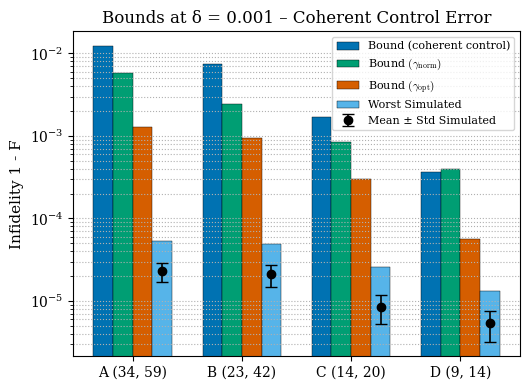

In [12]:
# Fix parameters
fixed_delta = 0.001
error_type = "coherent_control"

colors = ["#0072B2", "#009E73", "#56B4E9", "#D55E00"]


results = grouped_results[error_type]

devices_present = []
bound_b2_vals = []
bound_b4_vals = []
bound_cce_vals = []
worst_vals = []
mean_vals = []
std_vals = []

for dev in dev_names:
    key = (dev, fixed_delta)
    if key not in results:
        continue
    result = results[key]

    depth = result["depth"]
    num_gates = result["num_gates"]

    # Add device label with depth and num_gates
    devices_present.append(f"{dev_mapping[dev]} ({depth}, {num_gates})")

    # Bounds & worst-case
    bound_b2_vals.append(1 - result["worst_case_fidelity_bound_b2"])
    bound_b4_vals.append(1 - result["worst_case_fidelity_bound_b4"])
    bound_cce_vals.append(1 - result["fidelity_bound_coherent_control"])
    worst_vals.append(1 - result["worst_fidelity"])

    # Mean + std infidelity
    mean_vals.append(1 - result["average_fidelity"])
    std_vals.append(result["std_fidelity"])

# Plot grouped bar chart
x = np.arange(len(devices_present))  # positions for devices
width = 0.18  # bar width

fig, ax = plt.subplots(figsize=(5.4, 4))

# Bar plots
ax.bar(x - 1.5*width, bound_cce_vals, width, label="Bound (coherent control)", 
       color=colors[0], edgecolor="black", linewidth=0.3)
ax.bar(x - 0.5*width, bound_b4_vals, width, label=r"Bound $(\gamma_{\mathrm{norm}})$", 
       color=colors[1], edgecolor="black", linewidth=0.3)
ax.bar(x + 0.5*width, bound_b2_vals, width, label=r"Bound $(\gamma_{\mathrm{opt}})$", 
       color=colors[3], edgecolor="black", linewidth=0.3)
ax.bar(x + 1.5*width, worst_vals, width, label="Worst Simulated", 
       color=colors[2], edgecolor="black", linewidth=0.3)

# Mean + std errorbars (plotted as points with vertical error bars)
ax.errorbar(
    x+ 1.5*width, mean_vals, yerr=std_vals, fmt="o", 
    color="black", ecolor="black", elinewidth=1.2, capsize=4, 
    label="Mean ± Std Simulated"
)


# Axis formatting
ax.set_xticks(x)
ax.set_xticklabels(devices_present)
ax.set_ylabel("Infidelity 1 - F", fontsize=11)
ax.set_title(f"Bounds at δ = {fixed_delta} – {error_type.replace('_', ' ').title()} Error", fontsize=12)
ax.set_yscale("log")
ax.grid(True, axis="y", linestyle=":", which="both")
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig("QFT_bounds_delta_0.001_coherrent_control.pdf")


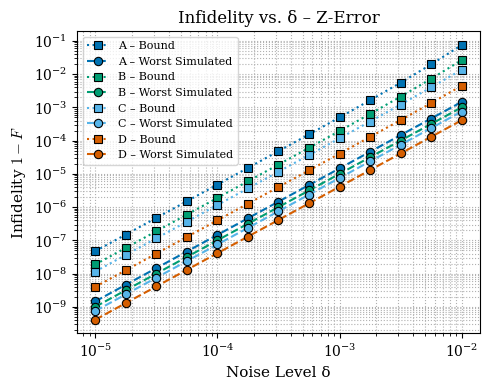

In [13]:

# ========== Define configuration ==========
n_qubits = 3
dev_names = ["rigetti", "ibm", "google", "quantinuum"]
dev_mapping = {
    "rigetti": "A",
    "ibm": "B",
    "google": "C",
    "quantinuum": "D"
}
error_types = ["z"]

colors = ["#0072B2", "#009E73", "#56B4E9", "#D55E00"]

colors = {
    "ibm": colors[1],
    "rigetti": colors[0],
    "quantinuum": colors[3],
    "google": colors[2]
}

lower_delta = 1e-5
upper_delta = 1e-2

# Group results by error_type
grouped_results = defaultdict(dict)
for key, result in all_results.items():
    n_q, dev, delta, error_type = key
    if n_q != n_qubits:
        continue  # Skip if not matching the target number of qubits
    grouped_results[error_type][(dev, delta)] = result

# ========== Plotting loop ==========
for error_type in error_types:
    results = grouped_results[error_type]

    delta_values = sorted(set(delta for (_, delta) in results.keys()))
    delta_values = [delta for delta in delta_values if lower_delta <= delta <= upper_delta]
    fig, ax = plt.subplots(figsize=(5, 4))

    for dev in dev_names:
        worst_fidelities = []
        bound_b2 = []
        bound_b4 = []
        bound_cce = []

        for delta in delta_values:
            key = (dev, delta)
            if key not in results:
                continue
            result = results[key]

            worst_fidelities.append(1 - result["worst_fidelity"])
            bound_b2.append(1 - result["worst_case_fidelity_bound_b2"])
            bound_b4.append(1 - result["worst_case_fidelity_bound_b4"])
            if error_type == "coherent_control":
                bound_cce.append(1 - result["fidelity_bound_coherent_control"])

        color = colors[dev]
        ax.plot(delta_values, bound_b2, label=f"{dev_mapping[dev]} – Bound", linestyle="dotted", color=color, marker="s", markerfacecolor=color, markeredgecolor="black", markeredgewidth=0.8)
        #ax.plot(delta_values, bound_b4, label=f"{dev_mapping[dev]} – Bound B4", linestyle="--", color=color)
        ax.plot(delta_values, worst_fidelities, label=f"{dev_mapping[dev]} – Worst Simulated", linestyle="dashed", color=color, marker="o", markerfacecolor=color, markeredgecolor="black", markeredgewidth=0.8)
        if error_type == "coherent_control":
            ax.plot(delta_values, bound_cce, label=f"{dev_mapping[dev]} – Bound CCE", linestyle="-.", color=color, marker="^", markerfacecolor=color, markeredgecolor="black", markeredgewidth=0.8)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Noise Level δ", fontsize=11)
    ax.set_ylabel("Infidelity $1 - F$", fontsize=11)
    ax.set_title(f"Infidelity vs. δ – {error_type.replace('_', ' ').title()}-Error", fontsize=12)
    # ax.set_xlim(left=1e-5, right=1e-2)
    # ax.set_ylim(bottom=1e-10, top=1e-1)
    ax.grid(True, which="both", ls=":")
    ax.legend(fontsize=8, ncol=1)
    plt.tight_layout()
    plt.savefig(f"QFT_Infidelity_vs_Delta_{error_type}_error.pdf")

(<Figure size 500x400 with 1 Axes>,
 <Axes: title={'center': 'Infidelity bound for different errors $\\delta=0.001$'}, ylabel='Worst-case Infidelity'>)

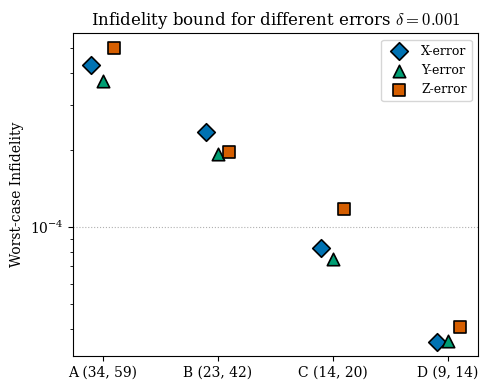

In [14]:


# === Configuration ===
results_dir = "../Results/QFT"  # or "./Results/QFT"
n_qubits = 3
dev_names = ["rigetti", "ibm", "google", "quantinuum"]
dev_mapping = {
    "rigetti": "A",
    "ibm": "B",
    "google": "C",
    "quantinuum": "D"
}

# Define error types (must match the `error_type` used in your result keys)
error_types = ["x", "y", "z", "coherent_control"]
error_types = ["x" , "y", "z"]

colors = ["#0072B2", "#009E73", "#56B4E9", "#D55E00"]


# Mapping for styling
error_labels = {
    "x": "X-error",
    "y": "Y-error",
    "z": "Z-error",
    "coherent_control": "Coherent-Control-error",
}
error_colors = {
    "x": colors[0],
    "y": colors[1],
    "z": colors[3],
    "coherent_control": colors[2],
}
error_markers = {
    "x": "D",
    "y": "^",
    "z": "s",
    "coherent_control": "o",
}



use_log_y = False  # Set True if you expect gamma values to span orders of magnitude

# === Load latest results file ===
result_files = sorted([f for f in os.listdir(results_dir) if f.startswith("results") and f.endswith(".pkl")])
latest_result_file = os.path.join(results_dir, result_files[-1])

with open(latest_result_file, "rb") as f:
    all_results = pickle.load(f)

# === Group results by error type ===
grouped_results = defaultdict(dict)
for key, result in all_results.items():
    n_q, dev, delta, error_type = key
    if n_q != n_qubits:
        continue
    grouped_results[error_type][(dev, delta)] = result

def extract_metric(grouped_results, dev_list, metric_key, delta_fixed):
    """
    Extract a metric (e.g., gamma or fidelity bound) per device from the grouped results dict.
    """
    metric_by_error = {}
    for error_type, results in grouped_results.items():
        metrics = []
        for dev in dev_list:
            # Use any delta to fetch metric (assumed delta-independent)
            keys = [(d, delta) for (d, delta) in results if (d == dev and delta == delta_fixed)]
            if not keys:
                continue
            metric_val = results[keys[0]][metric_key]
            metrics.append(metric_val)
        metric_by_error[error_type] = metrics
    return metric_by_error


def plot_metric(metric_key, ylabel, title, filename, delta_fixed=0.001, title_suffix=None):
    """
    Plot a given metric (e.g., gamma or fidelity bound) for all devices and error types.
    """
    x = np.arange(len(dev_names))
    fig, ax = plt.subplots(figsize=(5, 4))

    jitters = np.linspace(-0.1, 0.1, num=len(error_types))

    metric_by_error = extract_metric(grouped_results, dev_names, metric_key, delta_fixed)

    # === Collect device labels with depth and num_gates ===
    devices_present = []
    for dev in dev_names:
        # Get one result for this device at delta_fixed
        results_for_dev = grouped_results.get(error_types[0], {})
        key = (dev, delta_fixed)
        if key in results_for_dev:
            depth = results_for_dev[key]["depth"]
            num_gates = results_for_dev[key]["num_gates"]
            devices_present.append(f"{dev_mapping[dev]} ({depth}, {num_gates})")
        else:
            devices_present.append(dev_mapping[dev])  # fallback

    # === Plot metrics per error type ===
    for j, error_type in enumerate(error_types):
        if error_type not in metric_by_error:
            continue
        metrics = metric_by_error[error_type]
        if metric_key.startswith("worst_case_fidelity_bound") or metric_key.startswith("worst_case_fidelity"):
            # Convert fidelity to infidelity
            metrics = [1 - m for m in metrics]
        label = error_labels.get(error_type, error_type)
        color = error_colors.get(error_type, None)
        marker = error_markers.get(error_type, "o")

        ax.scatter(
            x + jitters[j],
            metrics,
            label=label,
            marker=marker,
            s=80,
            color=color,
            linewidths=1.2,
            edgecolors="black"
        )

    if metric_key.startswith("worst_case_fidelity_bound") or metric_key.startswith("worst_case_fidelity"):
        ax.set_yscale("log")

    ax.set_xticks(x)
    ax.set_xticklabels(devices_present)
    ax.set_ylabel(ylabel)
    ax.set_title(title if not title_suffix else f"{title} — {title_suffix}")
    ax.grid(True, axis="y", linestyle=":")
    ax.legend(fontsize=9)
    if use_log_y:
        ax.set_yscale("log")
    plt.tight_layout()
    plt.savefig(filename)
    return fig, ax



# === Generate plot ===
plot_metric("worst_case_fidelity_bound_b2", ylabel="Worst-case Infidelity", 
            title=r"Infidelity bound for different errors $\delta=0.001$",
            filename="QFT_worst_case_fidelity_bound_b2_per_device_different_error_types_0.001.pdf", delta_fixed=0.001)

